# Funathon 2023 - Sujet 5

Responsables :
- Antoine Palazzolo, SSP Lab
- Romain Avouac, DIIT

# Analyse textuelle des commentaires clients de services de commande de repas en ligne

## Avant de commencer...

Ce sujet, disponible uniquement en Python, porte sur deux thématiques principales :
- Le web scraping
- Le NLP

Les deux parties sont indépendantes l'une de l'autre, il est donc possible de n'en faire qu'une des deux.

Si jamais vous n'êtes pas familiers avec l'un de ces sujets (ou les deux), nous ne saurions que trop vous recommander de jeter un oeil aux ressources suivantes :
- Débuter en web scraping : https://pythonds.linogaliana.fr/webscraping/
- Web scraping et bonnes pratiques : https://github.com/InseeFrLab/formation-webscraping
- Débuter en NLP : https://pythonds.linogaliana.fr/course/nlp/

Exécutez la cellule ci-dessous pour installer les packages nécessaires au sujet :

In [ ]:
!pip install --quiet -r requirements.txt

## Partie 1 : Scraping d'avis sur Trustpilot

Pour pouvoir faire de l'analyse textuelle de commentaires clients, la première chose dont nous avons besoin c'est justement d'une base d'avis et de commentaires.
Vous pourrez trouver de tels avis sur à peu près n'importe quel site de vente en ligne ou bien sur un certain nombre de comparateurs.
En revanche, comment récupérer l'information depuis une page Internet pour nous constituer un jeu de données sur lequel travailler ?

Eh bien c'est justement là qu'intervient le web scraping, qui permet de collecter automatiquement de l'information d'un site web, que ce soit du texte, des images, des tableaux, sans avoir à parcourir toutes les pages soi-même en faisant un copier-coller à la main du contenu.
Le web scraping est donc un outil très puissant, mais à utiliser avec des pincettes.
Cela doit plutôt être vu comme un dernier recours, lorsqu'il n'est pas possible d'accéder aux données plus facilement.

En effet, de nombreuses contraintes juridiques encadrent par exemple le webscraping, il n'est pas possible de faire ce que l'on veut.
Qui plus est, de plus en plus de sites apprennent à se défendre contre cette collecte automatique de leurs données, rendant la tâche plus difficile.
Pour en savoir plus sur ces thématiques, n'hésitez pas à consulter cette formation : https://inseefrlab.github.io/formation-webscraping/.

<br>

Les données mises à disposition pour ce sujet ont été extraites du site https://fr.trustpilot.com/.
Votre première tâche va être de créer votre propre scraper pour pouvoir recréer une base similaire.

Afin de ne pas surcharger le traffic du site, nous n'allons pas vous demander d'en scraper l'intégralité.
Vous allez donc vous limiter à une entreprise de votre choix parmi celles de la catégorie _takeaway_ : https://fr.trustpilot.com/categories/takeaway.
Cliquez sur le lien et promenez-vous sur le site.

### 1. Bien préparer son scraping : découvrir le site ciblé

La première chose à faire pour tout bon adepte de scraping, c'est apprendre à connaître la page web cible :
- A quoi ressemble l'url du site ? Y a-t-il un radical commun lorsque l'on passe d'une page à une autre ? Par exemple ici lorsque l'on change d'entreprise comparée ou que l'on va chercher les avis les plus reculés ?
- Quelles sont les informations disponibles sur la page ? Y a-t-il besoin de cliquer sur un bouton pour les faire apparaître ?
- Les différentes pages que je souhaite scraper ont-elles bien des formats similaires ? La construction des pages change-t-elle d'une entreprise comparée à une autre ?

<br>

Il faut ensuite aller un peu plus loin dans l'analyse et regarder la structure HTML de la page ciblée.
Si vous n'êtes pas familiers avec cette partie, n'hésitez pas à consulter les ressources précédemment citées.

Tout d'abord, choisissez l'entreprise dont vous allez extraire les commentaires et cliquez sur sa page Trustpilot.
A présent, après un clic droit sur un élément de la page, il suffit de cliquer sur "Inspecter l'élément" pour naviguer dans l'architecture de la page et analyser le positionnement de l'élément sélectionné.
Cliquez sur divers éléments de la page pour vous familiariser avec sa structure.
- Comment sont rangés les commentaires ? Comprenez-vous bien l'arborescence de la page ?
- Regardez les balises autour de chaque note, y a-t-il un pattern ou un élément commun qui permet de les identifier et les distinguer des autres ?

### 2. Premiers pas : récupérer l'information du nombre de pages

#### Variables globales

In [ ]:
radical_trustpilot = '' # TODO
company = '' # TODO

url_company = radical_trustpilot + company

Maintenant que vous avez votre premier lien à scraper, il va falloir envoyer une __requête__ au site pour demander à en récupérer le contenu, sous le format HTML.
C'est sur le contenu retourné que nous travaillerons ensuite.

En Python, un package permet facilement de faire ces requêtes, il s'agit de _requests_, et plus précisément de la fonction ```requests.get()```, qui prend en argument l'url ciblé.
En plus du lien à requêter, la fonction peut prendre d'autres arguments, appelés __headers__, comme _User_Agent_ ou _From_ qui permettent de s'identifier lors de la requête envoyée au site.

Pourquoi s'identifier me demanderez-vous ? Eh bien tout d'abord parce qu'il s'agit là d'une bonne pratique de scraping.
Les sites reçoivent parfois énormément de requêtes sur leurs pages, par exemple à cause de scrapers trop gourmands, et cela peut leur créer des problèmes.
Ils peuvent donc être amenés à par exemple bloquer les adresses IP des utilisateurs jugés abusifs.
S'identifier clairement dans ses requêtes, en explicitant le but de la collecte, permet de faire preuve de transparence.
Même si en pratique cela n'arrive que très peu, cela laisse alors la possibilité au propriétaire du site de contacter le scraper afin d'avoir plus d'informations sur le but de la collecte, et possiblement offrir l'accès aux données sans scraping.

Une autre bonne pratique pour ne pas être trop agressif vis-à-vis du site scrapé est d'étaler ses requêtes dans le temps, par exemple en forçant votre code à prendre une pause d'au moins 3 secondes entre chaque requête effectuée si vous visitez plusieurs pages.

Ici, complétez les headers ci-dessous avec vos informations pour faire preuve de transparence auprès de Trustpilot :

In [ ]:
headers = {
    'User-Agent': '', # Nom, entité, but de la collecte, informations pertinentes
    'From': '' # Coordonnées à laisser au propriétaire du site en cas de besoin
}

Nous réutiliserons ces headers dans toutes les requêtes du sujet.

#### Créer sa première requête

In [ ]:
import requests
import time

Utilisez la fonction ```requests.get()``` et vos headers pour requêter votre site, puis utilisez la méthode ```.text``` pour récupérer le contenu HTML de la page désirée sous forme de texte.

Vous pouvez aussi déjà prendre le réflexe d'ajouter un ```time.sleep(3)``` à l'issue de chaque requête effectuée pour ne pas surcharger le site lorsque nous aurons davantage de requêts à faire.

In [ ]:
request_text = '' # TODO

print(request_text)

Si vous avez bien fait les choses, vous devriez maintenant avoir quelque chose d'assez illisible, c'est normal.
Il va maintenant falloir faire appel à un autre package pour __parser__ cette chaîne de caractères en une arborescence plus exploitable.

#### Parsing d'un document HTML : BeautifulSoup

La fonction ```BeautifulSoup()```, du package du même nom, est ce qui va nous permettre de faire ce parsing.
Rien de tel que l'essayer sur notre texte pour voir quel est son effet :

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
soup = '' # TODO

print(soup)

Normalement ça a déjà une meilleure tête !
On dira que le contenu HTML est désormais sous la forme d'une _soupe_.
L'idée maintenant va être de naviguer parmi l'arborescence des balises dans cette _soupe_ pour aller chercher l'information que l'on souhaite.

#### Chercher un élément dans l'arborescence

Deux méthodes sont particulièrement utiles lorsque l'on travaille avec BeautifulSoup :

- ```soup.find(type_de_balise, {'class': classe_de_la_balise)```, pour trouver le premier le premier élément correspondant à la recherche effectuée
    + La méthode ```.text``` permet ensuite d'en extraire le contenu textuel affiché sur le site
- ```soup.find_all(type_de_balise, {'class': classe_de_la_balise)```, pour renvoyer la liste de tous les éléments correspondant à la recherche effectuée

Les types de balise sont souvent assez standards : ```div```, ```a```, ```span```.
Quant aux noms de classes, ils ne sont pas toujours très explicites, mais que cela ne vous décourage pas !

Pour commencer, entraînez-vous à manipuler ces deux fonctions en récupérant des informations diverses sur le site. Vous pouvez également imbriquer plusieurs de ces fonctions les unes après les autres, l'output d'une recherche pouvant être une plus petite _soupe_ pour donnée en input d'une nouvelle recherche.

Quand vous êtes prêts, utilisez les méthodes ci-dessus pour associer à la variable ```nb_pages``` le nombre de pages d'avis pour l'entreprise considérée.

In [ ]:
nb_pages = 0  # TODO

Indice : Le nombre de pages est accessible au bas de la page. En revanche, la balise contenant l'information et son nom de classe ne sont peut-être pas uniques...

#### Mise sous fonction (et corrigé)

Maintenant que vous avez compris le principe, il est temps de regrouper tout ce qui a été fait en une fonction ```get_nb_pages_review()``` prenant en entrée un cible et renvoyant le nombre de pages d'avis.
Attention cette fois à rajouter une condition d'exception si jamais aucune balise du type désirée n'est trouvée...

In [ ]:
def get_nb_pages_reviews(url_company):

    # TODO
    
    return 0

In [ ]:
url_test_1 = radical_trustpilot + "deligreens.com"
get_nb_pages_reviews(url_test_1)

In [ ]:
url_test_2 = radical_trustpilot + "entreprise_mystere.com"  # Entreprise qui n'existe pas
get_nb_pages_reviews(url_test_2)  # Doit pouvoir s'exécuter sans erreur

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_nb_pages_reviews(url_company):

    time.sleep(3)
    request_text = requests.get(url_company, headers=headers).text
    soup = BeautifulSoup(request_text, 'html.parser')

    try:
        boutons_pages = soup.find(
            'div', {'class':'styles_pagination__6VmQv'}
        ).find_all(
            'span', {'class':'typography_heading-xxs__QKBS8 typography_appearance-inherit__D7XqR typography_disableResponsiveSizing__OuNP7'}
        )
        last_page = int(boutons_pages[-2].text)  # Dernier bouton = "Page Suivante"
        return last_page

    except:
        return 0
```

</details>


### 3. Mise en pratique : récupérer les avis d'une entreprise

#### Récupérer les informations au sein d'une review donnée

In [ ]:
import re

from datetime import datetime

Imaginez que vous avez sous la main le code HTML (sous forme de _soupe_) relatif à une seule review sur votre page (vous pouvez voir en inspectant la page que chaque review est contenue dans une balise ```div``` distincte, les unes après les autres).

Nous allons maintenant tâcher de récupérer les informations relatives à une review à l'aide de la méthode ```.find()```. Complétez les fonctions ci-dessous, sans oublier de rattraper les exceptions s'il y a un problème quelconque avec votre review d'entrée.

Attention, les fonctions ci-dessous demandent parfois de récupérer autre chose que du texte, il faudra donc réfléchir à des alternatives à la méthode ```.text```.

In [ ]:
def get_note_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        note: Note de l'avis (entier entre 1 et 5)
    """

    # TODO
    
    return 0

Indices :
- Pour récupérer un texte dans une balise _img_, un argument supplémentaire peut être passé à la fonction ```.find()```,  il s'agit de ```alt=True```
- Penser à convertir le texte récupéré en une note sous la forme d'entier

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_note_review(review):
    
    try:
        texte_note = review.find(
            'div', {'class':'star-rating_starRating__4rrcf star-rating_medium__iN6Ty'}
        ).find('img', alt=True)['alt']
        note = int(texte_note[5])  # texte_note = "Noté x étoiles sur 5"
        return note

    except:
        return "Not found"
```

</details>

In [ ]:
def get_time_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        date: Date et heure de l'avis (datetime)
    """

    # TODO
    
    return 0



Indice : La fonction ```datetime.strptime()``` permet de convertir la chaîne de caractères récupérée en un format date.

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_time_review(review):
    
    try:
        str_date = review.find(
            'div', {'class':'typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_datesWrapper__RCEKH'}
        ).find('time')['datetime']
        date = datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S.%fZ")  # str_date = 'YYYY-MM-DDThh:mm:ss.000Z'
        return date

    except:
        return "Not found"
```

</details>

In [ ]:
def get_title_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        title: Titre de la review (str)
    """

    # TODO
    
    return ''



<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_title_review(review):
    
    try:
        title = review.find(
            'h2', {'class':'typography_heading-s__f7029 typography_appearance-default__AAY17'}
        ).text
        return title

    except:
        return "Not found"
```

</details>

In [ ]:
def get_comment_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        comment: Commentaire associé à la review (str)
    """

    # TODO
    
    return ''



<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_comment_review(review):
    
    try:
        text = review.find(
            'p', {'class':'typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn'}
        ).text # Les balises <br> sont supprimées, on va donc forcer des espaces après les points
        text = re.sub(' +', ' ', text.replace('.', '. '))
        return text

    except:
        return "Not found"
```

</details>

#### Scraper toutes les reviews d'une entreprise

Nous sommes désormais capables de récupérer toutes les informations contenues dans une review donnée.
Reste maintenant à itérer sur l'ensemble des reviews d'une page, puis sur l'ensemble des pages (limité à 5 pages pour ne pas surcharger le site cible).

Complétez la fonction ci-dessous pour récupérer l'ensemble des informations extraites des reviews en un dataframe aisément manipulable.

Attention : bien penser à ajouter des pauses entre chaque requête d'au moins 3 secondes à l'aide de la commande ```time.sleep(3)```

In [ ]:
import pandas as pd

from tqdm import tqdm

In [ ]:
def scraping_one_company(url_company, limit_pages=True):

    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 5:
        nb_pages = 5
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):

        # TODO

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews

Indices :
- Quel va être l'url à requêter pour chaque page ?
- Souvenez-vous de la fonction ```.find_all()```

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def scraping_one_company(url_company, limit_pages=True):

    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 5:
        nb_pages = 5
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):

        time.sleep(3)
        url_page = url_company + '?page=' + str(page)
        
        try:
            request_text = requests.get(url_page, headers=headers).text
            soup = BeautifulSoup(request_text, 'html.parser')
            reviews = soup.find_all(
                'div', {'class':'styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ'}
            )
        except:
            reviews = []

        notes.extend(list(map(get_note_review, reviews)))
        times.extend(list(map(get_time_review, reviews)))
        titles.extend(list(map(get_title_review, reviews)))
        comments.extend(list(map(get_comment_review, reviews)))

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews
```

</details>

### 4. Collecte et vérification des résultats

Maintenant nos fonctions codées, il ne reste plus qu'à mettre en pratique et récupérer nos avis !

In [ ]:
df_reviews = scraping_one_company(url_company, limit_pages=True)

df_reviews

Lorsque l'on scrape des données sur Internet, la qualité attendue n'est pas toujours au rendez-vous.
Il convient donc de bien vérifier ce qui est obtenu en sortie pour ne pas avoir de mauvaises surprises.
Prenez un moment pour analyser vos données de sortie :

- Le format des colonnes est-il bon ? Les textes ont-ils tous bien une apparence lisible ?
- Y a-t-il des NaNs dans certaines colonnes ? Autrement dit des informations possiblement manquantes pour certaines reviews sur le site ?
- Avez-vous bien le nombre de lignes attendu en sortie ?

Pourquoi ne pas faire quelques visualisations avec matplotlib pour regarder à quoi ressemblent les distributions de nos variables ?

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Amusez-vous ici avec df_reviews


La partie scraping est à présent terminée.
La table que vous trouverez pour la seconde partie du sujet a été obtenue par scraping en itérant ce que vous avez recodé sur une liste donnée d'entreprises.

Si vous souhaitez en savoir plus sur le monde du web scraping ou si vous voulez réitérer l'expérience sur d'autres sites, n'hésitez pas à consulter les ressources mentionnées au début du sujet.

## Partie 2 : Analyse textuelle et NLP

La seconde partie du sujet consiste à analyser les données collectées. En particulier, étant donné que l'on dispose des commentaires laissés par les clients ainsi que leur note, il est intéressant de se demander dans quelle mesure il est possible de **prédire la note laissée par un client selon l'évaluation associée**. Pour se faire, on va devoir coupler les méthodes de traitement du langage naturel (NLP) et celles d'apprentissage statistique (machine learning).

### Import des données

Commençons par importer les données sur lesquelles on va baser notre analyse. Il s'agit ni plus ni moins que des données collectées dans la première partie.

In [65]:
import pandas as pd

In [66]:
df = pd.read_parquet("data/reviews_takeaway.parquet")

In [67]:
df = df[df["comment"] != "Not found"]

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18999 entries, 0 to 20437
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   note     18999 non-null  int64         
 1   date     18999 non-null  datetime64[ns]
 2   title    18999 non-null  object        
 3   comment  18999 non-null  object        
 4   company  18999 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 890.6+ KB


In [71]:
df.sample(10)

,note,date,title,comment,company
284,4,2023-05-01 03:15:08,Bonne expérience mais...,J'adore l'expérience que j'ai avec HelloFresh ...,hellofresh.fr
11727,3,2021-09-17 10:12:03,c'était ma première commande à Aurore…,c'était ma première commande à Aurore Market j...,auroremarket.fr
7625,5,2022-05-01 05:59:13,Système pratique pour établir ses menus,Système pratique pour établir ses menusPremièr...,hellofresh.fr
19117,4,2020-04-30 08:39:05,Très bon service y compris le suivi on…,Très bon service y compris le suivi on Line du...,ollca.com
6611,2,2022-07-05 06:13:50,Impossible de se désabonner sur le site…,Impossible de se désabonner sur le site où sur...,hellofresh.fr
427,2,2023-04-22 11:38:38,Livraison décalée - DLC limitée,Livraison prévue le 18/04 décalée d'un jour pa...,hellofresh.fr
12292,3,2021-05-27 19:29:31,Les délais de livraison sont de plus en…,Les délais de livraison sont de plus en plus l...,auroremarket.fr
9338,1,2021-10-07 07:35:18,Expérience désastreuse.,Expérience désastreuse. Je voulais simplement ...,hellofresh.fr
5296,5,2022-10-19 22:41:24,J’aime trop!!,"J’aime trop!!! les plats sont déjà programmé, ...",hellofresh.fr
14867,4,2020-07-25 15:42:36,Les produits sont parfaits...dommage…,Les produits sont parfaits. . . dommage que la...,auroremarket.fr


### Analyse descriptive

Avant de se lancer dans l'analyse textuelle à proprement parler, il est toujours préférable de commencer par une analyse descriptive très générale des données. Cela permet souvent de se faire une première idée de ce qu'elles contiennent, et de réaliser des premières hypothèses sur le lien entre commentaire et note, que la modélisation viendra ensuite confirmer ou infirmer.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Représentons tout d'abord la part des différentes entreprises dans notre base. On note une surreprésentation claire d'*hellofresh.fr*, et dans une moindre mesure d'*auroremarket.fr*. Dans une analyse rigoureuse de machine learning, il faut tenir compte de ce type de déséquilibre qui peuvent biaiser les prédictions du modèle.

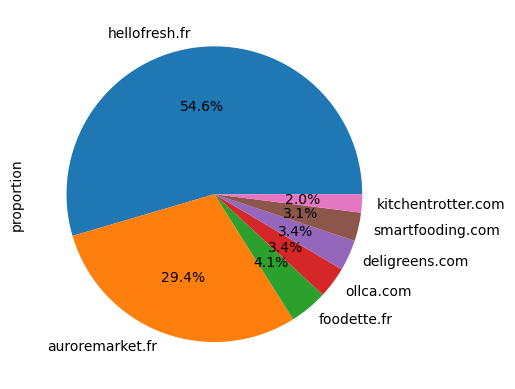

In [7]:
# Pourcentage d'avis en fonction de l'entreprise concernée
df["company"].value_counts(normalize=True).plot.pie(autopct="%.1f%%")
plt.show()

Intéressons nous ensuite à la répartition des notes. Il semble qu'une large majorité d'utilisateurs soient satisfaits de leur achat (4-5). De manière intéressante, il y autant d'avis donnant la note moyenne (3) qu'une note très mauvaise (1), mais peu d'avis donnant la note 2.

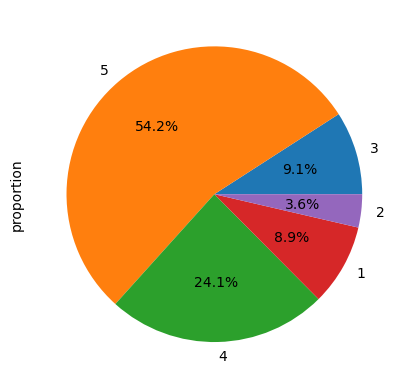

In [8]:
# Répartition des notes
df["note"].value_counts(normalize=True, sort=False).plot.pie(autopct="%.1f%%")
plt.show()

Pour réaliser le scraping, on a dû choisir les entreprises cibles et lire quelques avis afin de comprendre la structure HTML des pages. Ces premiers avis semblaient donner l'impression qu'*hellofresh.fr* était particulièrement plébiscité, là où au contraire *kitchentrotter.com* semblait très largement associé à des expériences négatives. Est-ce effectivement le cas dans les données complètes ? Pour le vérifier, on analyse la proportion des notes pour ces deux entreprises particulières. Le constat est sans appel et confirme nos premières conjectures !

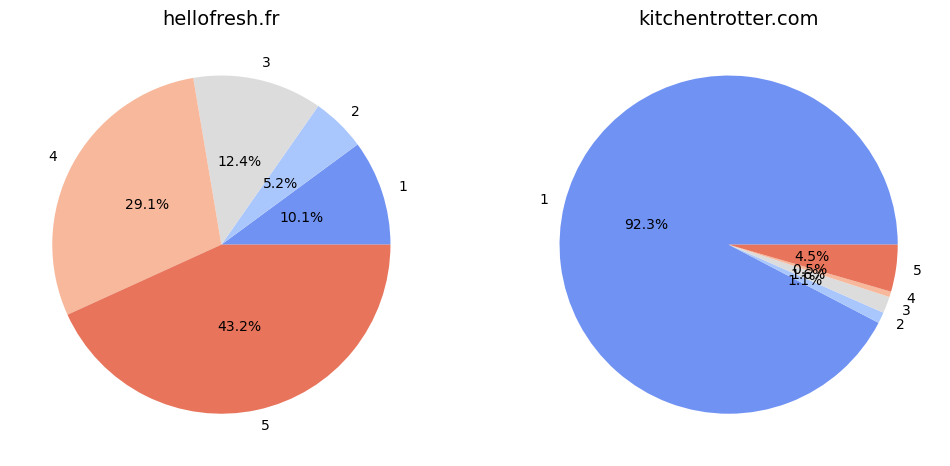

In [9]:
# Répartition des notes pour des entreprises données
plt.figure(figsize=[12,6])
plt.subplot(121)
colors = sns.color_palette('coolwarm', n_colors=5)
data = df[df['company'] == 'hellofresh.fr']["note"].value_counts(normalize=True, sort=False).sort_index()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", labels=labels, colors = colors, pctdistance=0.5)
plt.title("hellofresh.fr", fontsize=14);

plt.subplot(122)
data = df[df['company'] == 'kitchentrotter.com']["note"].value_counts(normalize=True, sort=False).sort_index()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", labels=labels, colors = colors, pctdistance=0.5)
plt.title("kitchentrotter.com", fontsize=14)

plt.show()

Intéressons-nous à présent au contenu des commentaires. Pour réaliser des analyses pertinentes à partir de données textuelles, il est indispensable d'utiliser les outils spécialisés du NLP, que ce soit pour nettoyer les données ou bien pour les exploiter. C'est ce que nous ferons dans les prochaines sections du tutoriel. Pour le moment, on peut d'ores et déjà s'intéresser à quelques caractéristiques très générales des textes, comme le nombre de caractères, la présence de majuscules ou de points d'exclamation, qui peuvent indiquer une certaine polarité des commentaires.

On représente d'abord le lien entre le nombre de caractères d'un commentaires et la note associée, sous forme de boîtes à moustache par note. La première représentation semble indiquer un certain gradient, mais on remarque également un grand nombre de valeurs extrêmes, symbolisées par les points. Ces valeurs extrêmes sont toujours intéressantes à analyser. Mais elles déforment l'échelle du graphique et peuvent empêcher de bien voir les écarts entre les boîtes.

<Axes: xlabel='note', ylabel='comment_length'>

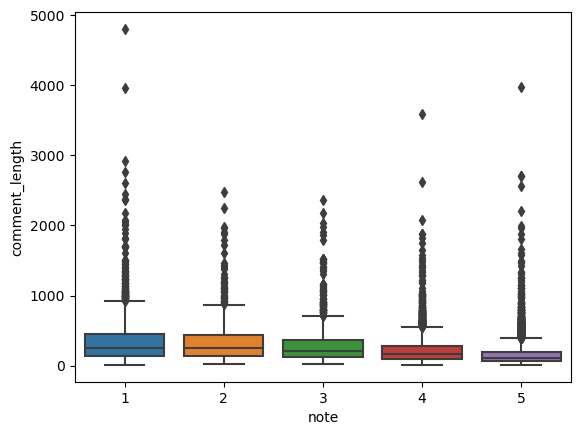

In [14]:
# Lien entre la longueur d'un commentaire et la note
df['comment_length'] = df['comment'].str.len()

sns.boxplot(x="note", y="comment_length", data=df)

Pour limiter cet effet, on s'intéresse aux commentaires de moins de 1000 caractères, soit la large majorité d'entre eux. On perçoit ainsi mieux le gradient existant entre les boîtes. Il semble à ce stade que les consommateurs insatisfaits donnent en moyenne des commentaires plus longs, et inversement, et cet effet semble assez continu avec le niveau de notes.

<Axes: xlabel='note', ylabel='comment_length'>

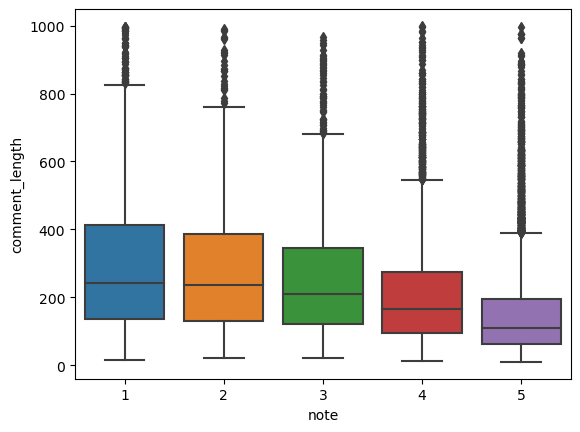

In [12]:
sns.boxplot(x="note", y="comment_length", data=df[df['comment_length'] < 1000])

On peut ensuite vouloir par exemple détecter des signes d'énervement, comme la présence de nombreuses majuscules ou de points d'exclamation. On pourrait faire ces calculs en Python, mais cela serait fastidieux à coder. Pour détecter la présence de caractères ou séries de caractères dans un texte (des *patterns*), on utilise une syntaxe particulière, celle des expressions régulières (*regex*).

La maîtrise des *regex* est un long voyage semé de frustration. Heureusement, on va se contenter dans ce tutoriel de motifs de base, très simples à comprendre. De plus, le site [regex101](https://regex101.com/) est très utile pour tester interactivement ses idées de regex : on y insère sa regex dans la case *REGULAR EXPRESSION* et le texte duquel on veut extraire de l'information dans la case *TEST STRING*, et l'on voit directement ce qui sera détecté (*matché*) dans le texte en question par la regex. Le site fournit par ailleurs, en bas à droite de la page, un pense-bête des principales syntaxes utilisées pour construire des regex. 

Pour utiliser des regex en `Python`, on utilise le package `re` (pas besoin de l'installer, il fait partie de la librarie standard). Ensuite, il y a à chaque fois deux étapes :
- on compile la regex que l'on souhaite utiliser via la fonction `re.compile`. Cela crée un "objet" qui modélise la regex souhaitée.
- on utilise les méthodes (fonctions associées à des objets) de l'objet pour extraire de l'information. En l'occurence, on va utiliser la méthode `findall` pour compter le nombre d'occurences du *pattern* dans le texte

Pour chaque cas, on définit une fonction qui prend en entrée un texte et retourne en sortie respectivement la proportion de majuscules et de points d'exclamation. Puis on utilise la méthode `apply` des séries `Pandas` pour appliquer ces fonctions à chacun de nos commentaires, en créant des nouvelles colonnes.

In [56]:
import re

In [57]:
# Regex pour extraire des infos du texte

def compte_majuscules(commentaire):
    r = re.compile("[A-Z]")  # Regex qui match toute majuscule
    capslock = r.findall(commentaire)  # Compte le nombre de majuscules dans le texte
    return len(capslock) / len(commentaire)  # Normalisation par la longueur du texte

def compte_points_exclamation(commentaire):
    r = re.compile("\!")  # Regex qui match tout point d'exclamation
    exclamation = r.findall(commentaire)  # Compte le nombre de points d'exclamation dans le texte
    return len(exclamation) / len(commentaire)  # Normalisation par la longueur du texte


df['part_majuscules'] = df['comment'].apply(compte_majuscules)
df['part_points_exclamation'] = df['comment'].apply(compte_points_exclamation)

In [59]:
df[["comment", "part_majuscules", "part_points_exclamation"]].head()

,comment,part_majuscules,part_points_exclamation
0,"Des produits manquants pour une recette, conta...",0.007833,0.000000
1,Les box hellofresh nous facilitent le quotidie...,0.013029,0.000000
2,Super idée recettes délicieuses. Tous les ingr...,0.014925,0.000000
3,"Jusqu’à présent satisfait de la marque, mais u...",0.015209,0.015209
4,Expérience d'achat inacceptable. Une chaîne du...,0.008715,0.006536


A présent, on va s'intéresser au lien entre la présence ou non de ces *patterns* dans les commentaires et la note donnée. Pour cela, on va utiliser des *violin plots*, du fait de leur forme en violon. L'idée est proche de la boîte à moustache, dans la mesure où l'on retrouve celle-ci et les statistiques qu'elle fournit (médiane, quartiles..) mais avec en plus un concept de **densité**, qui permet de voir rapidement la concentration des observations à certains niveaux de la distribution. Là encore, on va couper les valeurs extrêmes afin d'obtenir une échelle plus représentative de l'ensemble de la distribution.

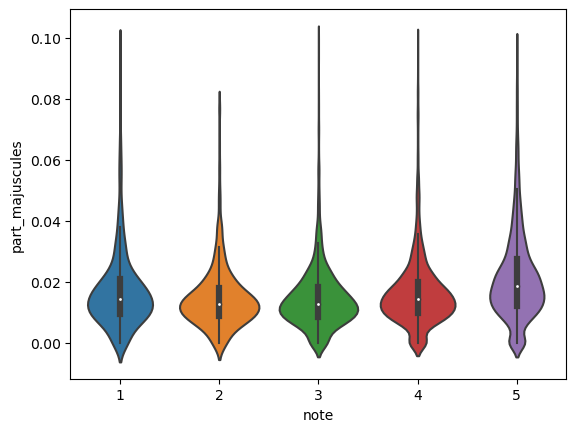

In [47]:
# Lien entre le nombre de majuscules et la note
data = df[df["part_majuscules"] < 0.1]
sns.violinplot(x="note", y="part_majuscules", data=data)
plt.show()

Le groupe des notes 5 se détache légèrement du reste, avec une part plus importante de majuscules en moyenne. Dans une moindre mesure, le groupe des notes 1 également. Le constat, s'il est difficile à établir statistiquement, n'en reste pas moins logique à première vue : les consommateurs très satisfaits et inversement très mécontents ont tendance à plus utiliser de majuscules que les autres.

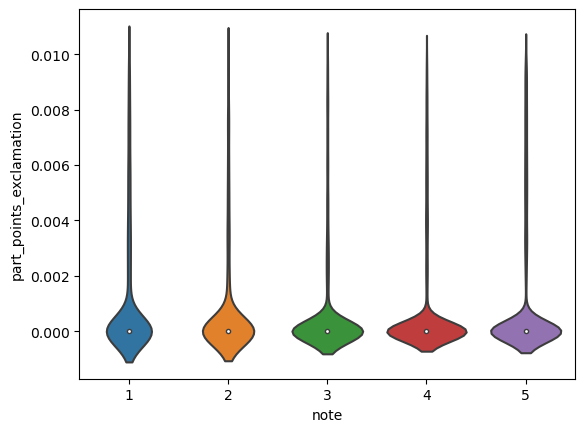

In [64]:
# Lien entre le nombre de points d'exclamation et la note
data = df[df["part_points_exclamation"] < 0.01]
sns.violinplot(x="note", y="part_points_exclamation", data=data)
plt.show()

Pour ce qui est des points d'exclamation, le constat est moins net. On aurait tendance à dire que les distributions des groupes des notes 1 et 2 sont plus étirées en longueur, ce qui pourrait indiquer une proportion un peu plus forte de points d'exclamation en moyenne.

Exercices possibles :
- nombre de points d'interrogation
- nombre de points d'exclamation successifs

Globalement, on voit que ces statistiques très généralistes sur les textes ont leur utilité, mais ne sauraient suffire à les distinguer. Il va donc falloir aller plus loin et **s'intéresser aux mots utilisés par les clients et en dégager une polarité**. Mais comment extraire l'information présente dans un texte sous une forme "compréhensible" par l'ordinateur, et donc utilisable pour prédire la note associée à un commentaire selon son contenu ?

La réponse à cette question n'est pas triviale, et de nombreuses méthodes concurrentes existent. Dans ce tutoriel, on va s'intéresser aux **méthodes classique de l'analyse textuelle, qui consistent à résumer l'information présente dans un texte par la fréquence des mots qu'il contient**. L'idée est intuitive : si l'on observe que les commentaires ayant une note faible contiennent souvent le mot "manquant" et inversement les commentaires ayant une note élevée le mot "parfait", il est clair que l'on pourra utiliser cette information pour prédire la note associée à un commentaire.

### Nettoyage et prétraitements

Pour qu'une analyse fréquentielle ait du sens, il est nécessaire au préalable de bien nettoyer et pré-traiter les données textuelles. L'idée générale de cette partie est qu'il est nécessaire de *normaliser* au maximum les textes afin que les fréquences calculées soient les plus pertinentes possibles.

Les premières normalisations à effectuer sont assez naturelles :
- on va transformer tous les textes en minuscules. On utilise pour ce faire les fonctions de `Pandas`.
- on va retirer tous les accents. On utilise pour ce faire la fonction `unidecode` du package du même nom, qui va transformer tous les caractères en leur représentation [ASCII](https://fr.wikipedia.org/wiki/American_Standard_Code_for_Information_Interchange) la plus proche, une nomenclature très basique qui contient seulement les caractères essentiels.

In [82]:
from unidecode import unidecode

In [83]:
df["comment"] = df["comment"].str.lower()
df["comment"] = df["comment"].apply(unidecode)

On va ensuite vouloir procéder à des normalisations un peu plus fines : supprimer la ponctuation, supprimer les chiffres, supprimer les mots trop fréquents, qui ne portent pas de sens mais peuvent biaiser l'analyse, etc. On pourrait essayer de faire tout ça à la main en `Python`, mais non seulement cela serait fastidieux, cela serait aussi assez compliqué en pratique : comment gère-t-on le cas d'un apostrophe ? Comment gère-t-on le cas des nombres décimaux séparés par une virgule ou un point selon les régions ? Comment définit-on un mot trop fréquent ?

Heureusement, de nombreuses personnes avant nous se sont posées ses questions, de sorte qu'il existe des outils très efficaces et bien pensés pour se faire. La librairie standard pour effectuer ce genre de traitements en `Python` s'appelle `nltk`. Dans ce tutoriel, on va plutôt présenter la librairie `spaCy`, plus moderne et souvent beaucoup plus performante lorsqu'il s'agit de traiter un large corpus de textes.

In [91]:
import spacy 

La grande force de `spaCy` est de proposer des modèles pré-entrainés pour de nombreuses langues. Très concrètement, il s'agit de modèles d'apprentissage statistique, en général entraînés via des méthodes de *deep-learning*, que l'on a entraîné à différentes tâches (ex : reconnaître les entités nommées, reconnaître la fonction grammaticale d'un mot, etc.) sur d'énormes volumes de texte. Par conséquent, ils sont capables de comprendre finement la structure du langage, et vont nous être utiles pour normaliser au maximum nos textes.

On commence donc par charger le modèle français. Pour limiter la bande passante, on prend le plus petit (`sm` = *small*), mais notons qu'on pourrait avoir de meilleurs résultats en utilisant les modèles `md` (*medium*) ou `lg` (*large*).

In [85]:
nlp = spacy.load("fr_core_news_sm")

L'objet `Python` que l'on récupère s'applique directement aux textes comme une fonction, et permet de faire une multitude d'actions sur ces textes. Regardons ces différentes possibilités avec un exemple simple.

In [86]:
comment = df["comment"][0]
doc = nlp(comment)

print(doc)

des produits manquants pour une recette, contact en chat, indemnise de 4,05 euros sur l appli qui ne peut pas etre utilise en meme temps qu une reduction donc sincerement autant ne rien avoir, nous n avons pas toujours le budget donc je trouve ca vraiment decevant. au final c est soit on paye le prix fort, soit avec des parrainages donc ces 4,05 nous n en profiterons jamais. decus


Jusque là rien de bien révolutionnaire : on voit qu'on peut imprimer l'objet `doc` renvoyé par le modèle lorsqu'on lui fournit un texte en entrée. Encore heureux..

Mais cet objet `doc` contient de fait tout un ensemble de caractérisations sur le texte qui vont nous être bien utiles. En particulier, il s'est chargé d'une tâche essentielle : la ***tokenisation***. Il s'agit du procédé qui consiste à convertir un texte en une série de *tokens*, i.e. de petites unités ayant une valeur sémantique. Il peut s'agir des mots, des caractères, de groupes de caractères, etc. Dans notre cas, on va vouloir faire une analyse fréquentielle à partir des termes, il fait donc sens de séparer le texte en mots.

L'objet `nlp` découpe par défaut le texte initial en *tokens*. Il suffit d'itérer sur cet objet pour passer en revue les différents *tokens*. Par ailleurs, `spaCy` détecte automatiquement un ensemble d'informations bien utiles sur les *tokens* :
- la fonction grammaticale (attribut `.tag_`)
- est-ce qu'il s'agit d'un *stop-word*, i.e. d'un mot très fréquent et donc qui ne porte généralement pas d'information pertinente (attribut `.is_stop`)
- est-ce qu'il s'agit d'un élément de ponctuation (attribut `.is_punct`)
- est-ce qu'il ne contient que des caractères alphabétiques (attribut `.is_alpha`)

Et tout un tas d'autres choses. N'hésitez pas à explorer la très complète [documentation](https://spacy.io/usage/linguistic-features) pour une vue détaillée des possibilités de `spaCy`.

In [87]:
for token in doc[:15]:
    print(token.text, token.tag_, token.is_stop, token.is_punct, token.is_alpha)

des DET True False True
produits NOUN False False True
manquants ADJ False False True
pour ADP True False True
une DET True False True
recette NOUN False False True
, PUNCT False True False
contact NOUN False False True
en ADP True False True
chat NOUN False False True
, PUNCT False True False
indemnise NOUN False False True
de ADP True False True
4,05 NUM False False False
euros NOUN False False True


En particulier, un dernier attribut va nous intéresser dans notre entreprise de normalisation des textes : la ***lemmatisation***. Cela consiste à remplacer chaque mot par sa forme neutre canonique. En effet, si l'on calcule les fréquences d'apparition des différents mots pour caractériser les textes, on voudrait par exemple que les mots "manquant", "manquants" ou encore "manquante" soient comptés comme un seul et même mot, dans la mesure où ils portent la même valeur sémantique.

In [88]:
for token in doc[:15]:
    print(token.text, token.lemma_)

des un
produits produit
manquants manquant
pour pour
une un
recette recette
, ,
contact contact
en en
chat chat
, ,
indemnise indemnise
de de
4,05 4,05
euros euro


Armé de tous ces attributs bien utiles que nous offre à peu de frais `spaCy`, on va normaliser nos textes de la manière suivante :
- suppression des *stop-words*
- suppression de la ponctuation
- suppression des mots non-alphabétiques (chiffres, etc.)
- suppression des *tokens* de trois caractères ou moins

Illustrons comment cela se fait pour un texte donné.

In [90]:
no_stop_lemma_list = []

for token in doc:
    # On rajoute un token à la liste s'il remplit les conditions suivantes
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        no_stop_lemma_list.append(token.lemma_)

# On concatène les éléments de la liste, séparés par un espace
no_stop_lemma = " ".join(no_stop_lemma_list)

print(doc)
print()
print(no_stop_lemma)

des produits manquants pour une recette, contact en chat, indemnise de 4,05 euros sur l appli qui ne peut pas etre utilise en meme temps qu une reduction donc sincerement autant ne rien avoir, nous n avons pas toujours le budget donc je trouve ca vraiment decevant. au final c est soit on paye le prix fort, soit avec des parrainages donc ces 4,05 nous n en profiterons jamais. decus

produit manquant recette contact chat indemnise euro appli utiliser temps reduction sinceremer autant rien budget trouver vraiment decevant final payer prix fort parrainage profiteron jamais decu


Pas mal ! Maintenant on voudrait bien appliquer cela à tous les textes de notre corpus. En réalité, même si cela ne s'est pas vu sur un seul document, ce processus est assez coûteux en temps. Heureusement, `spaCy` nous permet de largement l'accélérer :
- on va paralléliser les calculs, de sorte que 5 textes vont être normalisés en parallèle
- on va supprimer les fonctions de `spaCy` dont on ne va pas se servir en pratique

In [99]:
pipe = nlp.pipe(df["comment"], n_process=5,
                disable=["tagger", "parser", "attribute_ruler", "ner"])

Une fois l'objet `pipe` défini, on peut itérer sur les commentaires par une simple boucle. On va construire notre processus étage par étage :
- une fonction `preprocess_token` qui prend un *token* en entrée, retourne sa version lématisée si jamais il respecte les conditions énoncées précédemment, et une chaîne de caractères vide sinon
- une fonction `preprocess_text` qui prend en entrée un texte au format objet `spaCy` (i.e. un élément de l'objet `pipe`), qui applique à chaque *token* la fonction `preprocess_token` en supprimant au passage les *tokens* vides, et renvoie le texte normalisé sous la forme d'une seule chaîne de caractères

Il nous suffit ensuite d'appliquer la fonction `preprocess_text` à chaque élément de l'objet `pipe`, i.e. chaque commentaire, pour obtenir la liste des textes normalisés. Cette opération ne devrait pas prendre plus d'une minute.

In [100]:
def preprocess_token(token):
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        return token.lemma_
    else:
        return ""

def preprocess_text(text_nlp):
    text_pretraite_list = [preprocess_token(token) for token in text_nlp if token]
    text_pretraite = " ".join(text_pretraite_list)
    return text_pretraite

commentaires_pretraites = [preprocess_text(commentaire) for commentaire in pipe]

Finalement, on peut rajouter à notre dataset la version normalisée des commentaires, et vérifier que les résultats font effectivement sens.

In [97]:
df["comment_pretraite"] = commentaires_pretraites
df[["title", "comment", "comment_pretraite"]].head()

,title,comment,comment_pretraite
0,Des produits manquants pour une…,"des produits manquants pour une recette, conta...",produit manquant recette contact chat in...
1,Facile et pratique,les box hellofresh nous facilitent le quotidie...,box hellofresh faciliter quotidien pense...
2,Super idée recettes délicieuses.,super idee recettes delicieuses. tous les ingr...,super idee recette delicieuse ingredient f...
3,Service de livraison incompétent !,"jusqu'a present satisfait de la marque, mais u...",present satisfait marque service livra...
4,Expérience d'achat inacceptable,experience d'achat inacceptable. une chaine du...,experience achat inacceptable chaine froid...


### Analyse textuelle des commentaires

In [211]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [212]:
ngram_range=(1,1)
texts = df["comment_pretraite"]

vectorizer = CountVectorizer(ngram_range=ngram_range)
vectorizer.fit(texts)

vocab = vectorizer.get_feature_names_out()
print(f"Taille du vocabulaire : {len(vocab)} ")

Taille du vocabulaire : 13109 


In [213]:
vectorizer.transform(texts)

<18999x13109 sparse matrix of type '<class 'numpy.int64'>'
	with 275579 stored elements in Compressed Sparse Row format>

In [214]:
comptages = np.array(vectorizer.transform(texts).sum(0))[0]
comptages_voc = list(zip(vocab, comptages))
comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])
comptages_voc.head()

,mot,frequence
0,produit,8527
1,recette,7942
2,bon,6915
3,livraison,6307
4,bien,4569


<Axes: xlabel='frequence', ylabel='mot'>

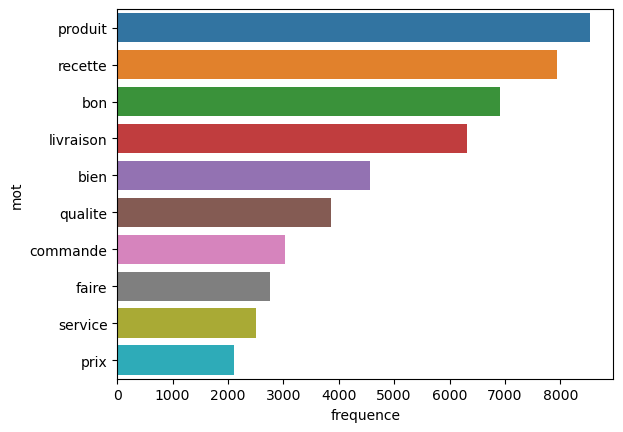

In [215]:
sns.barplot(x="frequence", y="mot", data=comptages_voc.head(10))

In [73]:
def plot_freq_n_grammes(commentaires, ngram_range=(1,1), n_results=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    vectorizer.fit(commentaires)
    vocab = vectorizer.get_feature_names_out()
    
    comptages = np.array(vectorizer.transform(commentaires).sum(0))[0]
    comptages_voc = list(zip(vocab, comptages))
    comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
    comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])
    
    sns.barplot(x="frequence", y="mot", data=comptages_voc.head(n_results))
    
    return comptages_voc

In [ ]:
_ = plot_freq_n_grammes(commentaires=df["comment_pretraite"], 
                        ngram_range=(1,1), 
                        n_results=10)

Exercice possible : faire varier le range des ngrammes 

In [74]:
_ = plot_freq_n_grammes(commentaires=df["comment_pretraite"], 
                        ngram_range=(2,2), 
                        n_results=10)

KeyError: 'comment_pretraite'

In [72]:
_ = plot_freq_n_grammes(commentaires=df["comment_pretraite"], 
                        ngram_range=(3,3), 
                        n_results=10)

NameError: name 'plot_freq_n_grammes' is not defined

Exercice possible : réaliser les mêmes plots en restreignant les données en entrée aux commentaires avec note 1, commentaires avec note 5, etc. et voir dans quelle mesure les top 10 changent et si c'est pertinent

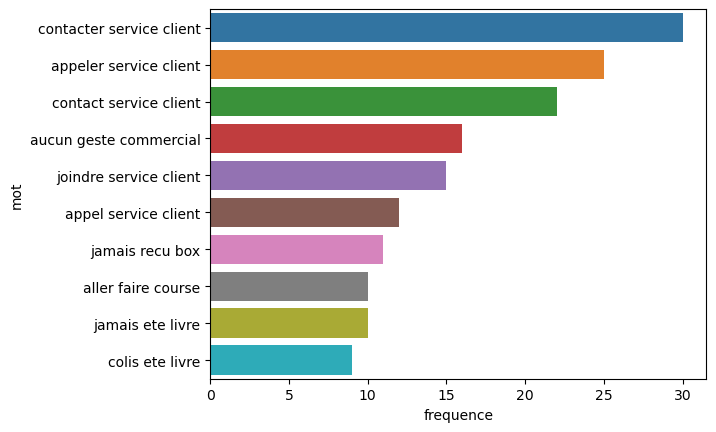

In [218]:
_ = plot_freq_n_grammes(commentaires=df[df["note"] == 1]["comment_pretraite"], 
                        ngram_range=(3,3), 
                        n_results=10)

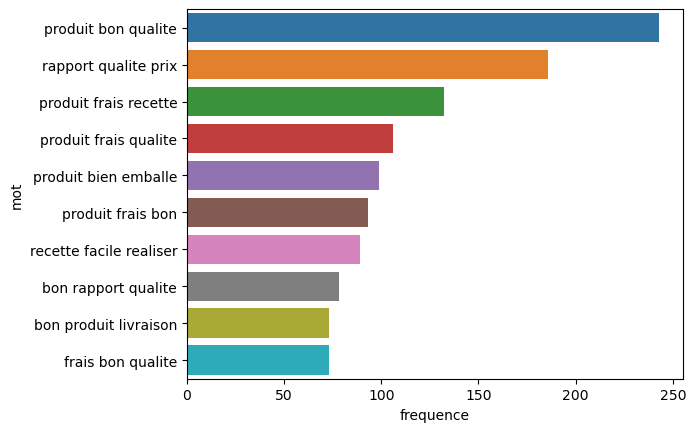

In [219]:
_ = plot_freq_n_grammes(commentaires=df[df["note"] == 5]["comment_pretraite"], 
                        ngram_range=(3,3), 
                        n_results=10)

### Apprentissage supervisé : prédiction de la note à partir du texte

TODO :
- expliquer tache de prédiction
- expliquer train/test split

In [220]:
from sklearn.model_selection import train_test_split

In [221]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [222]:
print(df_train.shape, df_test.shape)

(15199, 9) (3800, 9)


#### Approche "bag-of-words"

TODO : expliquer la vectorization et l'approche par comptages de mots "bag-of-words"

In [223]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVR

In [224]:
vectorizer = CountVectorizer(ngram_range=(1,3))

X_train = vectorizer.fit_transform(df_train["comment_pretraite"])
X_test = vectorizer.transform(df_test["comment_pretraite"])

voc = vectorizer.vocabulary_
print('Taille du vocabulaire : ', len(voc))

Taille du vocabulaire :  312452


In [225]:
y_train = df_train["note"]
y_test = df_test["note"]

In [226]:
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)

LinearSVR(max_iter=10000)

In [227]:
y_pred = svr.predict(X_test)
y_pred

array([2.34676546, 3.61998471, 5.16712773, ..., 5.05172965, 4.6193401 ,
       4.68445977])

TODO : analyse quantitative avec une RMSE/MAE

<Axes: xlabel='note', ylabel='note_predite'>

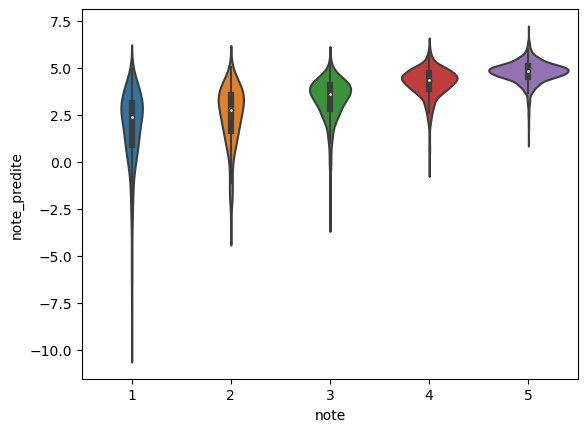

In [228]:
# Analyse qualitative
data = pd.DataFrame({'note': y_test, 'note_predite': y_pred})

sns.violinplot(x="note", y="note_predite", data=data)

In [ ]:
sns.violinplot(x="note", y="note_predite", data=data[data["note_predite"] >= 0])

#### Approche TF-IDF

TODO : expliquer TF-IDF

Exercice : reproduire l'analyse précédente en utilisatn un vectorize TF-IDF au lieu du countvectorizer, à partir de la doc de sklearn

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [231]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))

X_train = vectorizer.fit_transform(df_train["comment_pretraite"])
X_test = vectorizer.transform(df_test["comment_pretraite"])

In [232]:
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)

LinearSVR(max_iter=10000)

In [233]:
y_pred = svr.predict(X_test)
y_pred

array([2.89444519, 3.5255311 , 5.14263926, ..., 5.11716009, 5.0413955 ,
       4.92552821])

TODO : analyse quantitative avec une RMSE/MAE

<Axes: xlabel='note', ylabel='note_predite'>

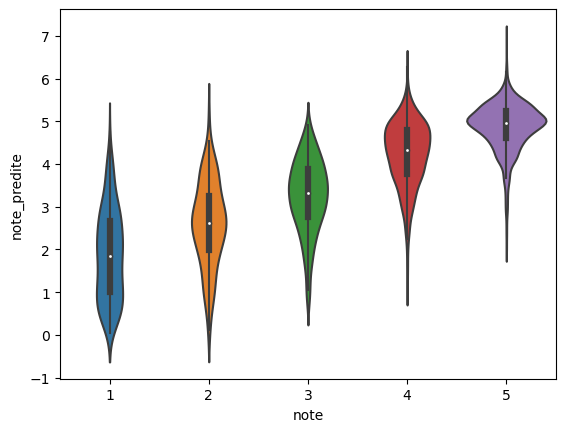

In [234]:
data = pd.DataFrame({'note': y_test, 'note_predite': y_pred})

sns.violinplot(x="note", y="note_predite", data=data[data["note_predite"] >= 0])

TODO :
- conclure sur les diff de perfs entre les deux approches

Exercice possible (avancé) : 
- rajouter des régresseurs à l'approche TF-IDF et voir si les perfs augmentent :
  - indicatrice sur le site dont vient le commentaire
  - indicatrice sur l'année du commentaire pour tenir compte de l'évolution des marques
  - proportion de points exclamation
  - proportion de majuscules

### Apprentissage non-supervisé : détection de sujets

TODO : expliquer LDA

In [235]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model

In [236]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(1,3))
freq_matrix = vectorizer.fit_transform(df["comment_pretraite"])

In [241]:
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(freq_matrix)

LatentDirichletAllocation(n_components=20, random_state=0)

TODO : expliquer LDAviz et le paramètre d'arbitrage fréquence/salience

In [242]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, freq_matrix, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.140312  0.205678       1        1  9.673664
15     0.118836 -0.145338       2        1  7.656162
1     -0.144998  0.146663       3        1  7.299063
17     0.220836  0.113066       4        1  6.175982
11    -0.169948 -0.024095       5        1  6.063145
16     0.195088  0.191331       6        1  5.678973
8      0.221648  0.003587       7        1  5.603858
9     -0.231983  0.081488       8        1  5.145611
2     -0.190966 -0.089455       9        1  5.116665
12     0.092709 -0.306073      10        1  5.077297
7     -0.097611 -0.045966      11        1  4.447700
5     -0.162570  0.096390      12        1  4.411292
3     -0.192880  0.095301      13        1  4.248978
4      0.213945 -0.049553      14        1  4.156101
10    -0.065517  0.045934      15        1  3.850278
18    -0.044571 -0.178079      16        1  3.449103
14     0.038440 -0.024311      17        1  3.351628
19    -0.013949 -0.206040      18        1  2.964860
0     -0.003426  0.010810      19        1  2.853501
6      0.076603  0.078664      20        1  2.776138, topic_info=            Term         Freq        Total Category  logprob  loglift
8599     produit  8217.000000  8217.000000  Default  30.0000  30.0000
9550     recette  7677.000000  7677.000000  Default  29.0000  29.0000
6171   livraison  6099.000000  6099.000000  Default  28.0000  28.0000
9048     qualite  3724.000000  3724.000000  Default  27.0000  27.0000
8438        prix  2032.000000  2032.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
8599     produit    73.612727  8217.921745  Topic20  -5.0573  -1.1311
1589         box    58.863495  1716.384859  Topic20  -5.2809   0.2114
9550     recette    64.621259  7677.812498  Topic20  -5.1876  -1.1934
4667     falloir    49.859714   791.969705  Topic20  -5.4470   0.8188
5481  hellofresh    49.190300  1013.435174  Topic20  -5.4605   0.5587

[1466 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
3          4  0.678702         abime
3          7  0.111685         abime
3         11  0.120276         abime
3         14  0.042956         abime
3         17  0.017182         abime
...      ...       ...           ...
12406     19  0.110246          être
12406     20  0.013939          être
12413      9  0.078689  être conquis
12413     19  0.865581  être conquis
12428      4  0.945687   être livree

[4447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 16, 2, 18, 12, 17, 9, 10, 3, 13, 8, 6, 4, 5, 11, 19, 15, 20, 1, 7])

Exercice possible :
- faire varier le paramètre lambda dans LDAvis et trouver la valeur optimale pour l'interprétabilité (généralement qq part entre 0.4-0.6)
- faire varier le nombre de sujets (n_components) pour trouver de meilleurs clusters
- faire varier le preprocessing (min_df, max_df, ngram_range) et voir l'influence